
# Ciclos para el oro y la plata

## 1. Naturaleza de los Metales Preciosos como Activos

* **Refugio de valor:** Actúan como protección durante periodos de incertidumbre económica y geopolítica.
* **Cobertura contra inflación:** Protegen contra la depreciación de las divisas *fiat*.
* **Reserva de valor histórica:** Cuentan con miles de años de historia como respaldo financiero.
* **Descorrelación:** Presentan una baja correlación con el mercado de acciones en momentos de estrés financiero.

## 2. Drivers Principales de Ciclos Alcistas

### a) Política Monetaria

* **Tasas de interés reales bajas/negativas:** Cuando el rendimiento del dinero es bajo, el oro tiende a subir.
* **Expansión monetaria (QE):** El aumento de la masa monetaria favorece a los metales.
* **Debilitamiento del USD:** Un dólar débil suele impulsar el precio de los *commodities*.

### b) Inflación

* **Alta inflación:** Aumenta la demanda de activos de cobertura.
* **Expectativas inflacionarias:** Generan compras anticipadas por parte de inversores.

### c) Crisis Geopolíticas y Financieras

* Conflictos bélicos y tensiones comerciales.
* Crisis bancarias y de deuda soberana.
* Pérdida de confianza generalizada en el sistema financiero.

### d) Demanda Física

* **Bancos Centrales:** Diversificación de reservas mediante la compra masiva de oro.
* **Demanda Industrial:** Especialmente la plata en sectores tecnológicos y energía solar.
* **Inversión y Joyería:** Fuerte demanda proveniente de mercados asiáticos.

---

## 3. Diferencias: Oro vs. Plata

| Característica | Oro | Plata |
| --- | --- | --- |
| **Volatilidad** | Más estable, menor volatilidad. | Mayor volatilidad (mayor *beta*). |
| **Función** | Reserva de valor más pura. | Doble función: monetaria + industrial. |
| **Sensibilidad** | Domina la función monetaria. | Sensible a ciclos económicos industriales. |
| **Retornos** | Crecimiento constante. | Potencial de retornos más altos en mercados alcistas. |

> **Nota sobre el Ratio:** El ratio Oro/Plata se mantiene históricamente entre **40:1 y 80:1**.

## 4. Ratio Oro/Plata

* **Promedio histórico:** ~65:1.
* **Extremos:** Puede llegar a **100:1** (indica plata barata) o **40:1** (indica plata cara).
* **Estrategia:** Es una herramienta útil para realizar rotaciones tácticas entre ambos metales.


In [1]:
# ============================================================================
# ANÁLISIS DE CICLOS ALCISTAS EN METALES PRECIOSOS (ORO Y PLATA)
# ============================================================================

# ============================================================================
# CELDA 1: Importación de librerías
# ============================================================================
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('classic')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✓ Librerías importadas correctamente")
print(f"Fecha de análisis: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ Librerías importadas correctamente
Fecha de análisis: 2026-01-30 15:07:55


### ¿Por qué implementar persistencia en bases de datos? Porque yfinance tiene límites de rate y no queremos estar descargando 6,000+ registros cada vez que corremos el análisis. 

#### Tres tablas: precios_oro, precios_plata, y metadatos para trackear la última actualización.

In [2]:
# ============================================================================
# CELDA 2: Configuración de base de datos SQLite
# ============================================================================
# Crear/conectar a base de datos
db_path = 'metales_preciosos.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Crear tablas si no existen
cursor.execute('''
CREATE TABLE IF NOT EXISTS precios_oro (
    fecha DATE PRIMARY KEY,
    precio_cierre REAL,
    precio_apertura REAL,
    precio_maximo REAL,
    precio_minimo REAL,
    volumen INTEGER
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS precios_plata (
    fecha DATE PRIMARY KEY,
    precio_cierre REAL,
    precio_apertura REAL,
    precio_maximo REAL,
    precio_minimo REAL,
    volumen INTEGER
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS metadatos (
    metal TEXT PRIMARY KEY,
    ultima_actualizacion TIMESTAMP,
    registros_totales INTEGER
)
''')

conn.commit()
print(f"✓ Base de datos SQLite creada/conectada: {db_path}")

✓ Base de datos SQLite creada/conectada: metales_preciosos.db


In [3]:
# ============================================================================
# CELDA 3: Función para descargar y almacenar datos
# ============================================================================
def descargar_y_guardar_datos(ticker, tabla, metal_nombre):
    """
    Descarga datos de yfinance y los almacena en SQLite
    """
    print(f"\n{'='*60}")
    print(f"Descargando datos de {metal_nombre} ({ticker})...")
    print(f"{'='*60}")
    
    # Verificar última actualización
    cursor.execute("SELECT ultima_actualizacion FROM metadatos WHERE metal = ?", (metal_nombre,))
    resultado = cursor.fetchone()
    
    # Definir rango de fechas
    fecha_fin = datetime.now()
    
    # Descargar datos desde el inicio disponible hasta hoy
    data = yf.download(ticker, start="1970-01-01", end=fecha_fin.strftime('%Y-%m-%d'), progress=False, multi_level_index=False, auto_adjust=False)
    
    if data.empty:
        print(f"⚠ No se pudieron descargar datos para {ticker}")
        return None
    
    # Preparar DataFrame
    data.reset_index(inplace=True)
    data.columns = ['fecha', 'precio_apertura', 'precio_cierre', 'precio_maximo', 
                    'precio_minimo', 'volumen', 'adj_close']
    data = data[['fecha', 'precio_cierre', 'precio_apertura', 'precio_maximo', 
                 'precio_minimo', 'volumen']]
    data['fecha'] = pd.to_datetime(data['fecha']).dt.strftime('%Y-%m-%d')
    
    # Limpiar tabla existente e insertar nuevos datos
    cursor.execute(f"DELETE FROM {tabla}")
    data.to_sql(tabla, conn, if_exists='append', index=False)
    
    # Actualizar metadatos
    cursor.execute('''
        INSERT OR REPLACE INTO metadatos (metal, ultima_actualizacion, registros_totales)
        VALUES (?, ?, ?)
    ''', (metal_nombre, datetime.now(), len(data)))
    
    conn.commit()
    
    print(f"✓ Datos descargados: {len(data)} registros")
    print(f"✓ Rango: {data['fecha'].min()} a {data['fecha'].max()}")
    print(f"✓ Almacenados en tabla '{tabla}'")
    
    return data

# Descargar datos
oro_data = descargar_y_guardar_datos('GC=F', 'precios_oro', 'Oro')
plata_data = descargar_y_guardar_datos('SI=F', 'precios_plata', 'Plata')


Descargando datos de Oro (GC=F)...
✓ Datos descargados: 6377 registros
✓ Rango: 2000-08-30 a 2026-01-29
✓ Almacenados en tabla 'precios_oro'

Descargando datos de Plata (SI=F)...
✓ Datos descargados: 6379 registros
✓ Rango: 2000-08-30 a 2026-01-29
✓ Almacenados en tabla 'precios_plata'


In [4]:
# ============================================================================
# CELDA 4: Cargar datos desde SQLite
# ============================================================================
def cargar_datos_desde_db(tabla, metal_nombre):
    """
    Carga datos desde SQLite
    """
    query = f"SELECT * FROM {tabla} ORDER BY fecha"
    df = pd.read_sql_query(query, conn)
    df['fecha'] = pd.to_datetime(df['fecha'])
    df.set_index('fecha', inplace=True)
    print(f"✓ {metal_nombre}: {len(df)} registros cargados desde DB")
    return df

# Cargar datos
df_oro = cargar_datos_desde_db('precios_oro', 'Oro')
df_plata = cargar_datos_desde_db('precios_plata', 'Plata')

print(f"\nRango temporal de datos:")
print(f"Oro: {df_oro.index.min().date()} a {df_oro.index.max().date()}")
print(f"Plata: {df_plata.index.min().date()} a {df_plata.index.max().date()}")

✓ Oro: 6377 registros cargados desde DB
✓ Plata: 6379 registros cargados desde DB

Rango temporal de datos:
Oro: 2000-08-30 a 2026-01-29
Plata: 2000-08-30 a 2026-01-29


In [5]:
# ============================================================================
# CELDA 5: Cálculo de retornos y estadísticas básicas
# ============================================================================
# Calcular retornos
df_oro['retorno_diario'] = df_oro['precio_cierre'].pct_change()
df_oro['retorno_acumulado'] = (1 + df_oro['retorno_diario']).cumprod() - 1

df_plata['retorno_diario'] = df_plata['precio_cierre'].pct_change()
df_plata['retorno_acumulado'] = (1 + df_plata['retorno_diario']).cumprod() - 1

# Estadísticas descriptivas
print("\n" + "="*60)
print("ESTADÍSTICAS DESCRIPTIVAS - ORO")
print("="*60)
print(df_oro['precio_cierre'].describe())
print(f"\nRetorno anualizado: {df_oro['retorno_diario'].mean() * 252 * 100:.2f}%")
print(f"Volatilidad anualizada: {df_oro['retorno_diario'].std() * np.sqrt(252) * 100:.2f}%")

print("\n" + "="*60)
print("ESTADÍSTICAS DESCRIPTIVAS - PLATA")
print("="*60)
print(df_plata['precio_cierre'].describe())
print(f"\nRetorno anualizado: {df_plata['retorno_diario'].mean() * 252 * 100:.2f}%")
print(f"Volatilidad anualizada: {df_plata['retorno_diario'].std() * np.sqrt(252) * 100:.2f}%")


ESTADÍSTICAS DESCRIPTIVAS - ORO
count    6377.000000
mean     1262.016653
std       752.690792
min       255.100006
25%       650.599976
50%      1249.300049
75%      1685.500000
max      5318.399902
Name: precio_cierre, dtype: float64

Retorno anualizado: 13.25%
Volatilidad anualizada: 17.43%

ESTADÍSTICAS DESCRIPTIVAS - PLATA
count    6379.000000
mean       18.178840
std        10.473310
min         4.026000
25%        12.192500
50%        17.011000
75%        23.566000
max       115.080002
Name: precio_cierre, dtype: float64

Retorno anualizado: 17.52%
Volatilidad anualizada: 31.83%


In [6]:
# ============================================================================
# CELDA 6: Identificación de ciclos alcistas
# ============================================================================
def identificar_ciclos_alcistas(df, nombre_metal, ventana_ma=200, umbral_alcista=0.20):
    """
    Identifica ciclos alcistas usando media móvil y drawdowns
    
    Parámetros:
    - ventana_ma: ventana para media móvil (200 días ~1 año de trading)
    - umbral_alcista: incremento mínimo para considerar ciclo alcista (20%)
    """
    df = df.copy()
    
    # Calcular media móvil
    df['ma_200'] = df['precio_cierre'].rolling(window=ventana_ma).mean()
    
    # Calcular máximos históricos y drawdowns
    df['max_historico'] = df['precio_cierre'].cummax()
    df['drawdown'] = (df['precio_cierre'] - df['max_historico']) / df['max_historico']
    
    # Identificar tendencia (precio > MA200)
    df['alcista'] = df['precio_cierre'] > df['ma_200']
    
    # Encontrar ciclos
    ciclos = []
    en_ciclo = False
    inicio_ciclo = None
    precio_inicio = None
    
    for i in range(len(df)):
        if df['alcista'].iloc[i] and not en_ciclo:
            # Inicio de ciclo alcista
            en_ciclo = True
            inicio_ciclo = df.index[i]
            precio_inicio = df['precio_cierre'].iloc[i]
            
        elif not df['alcista'].iloc[i] and en_ciclo:
            # Fin de ciclo alcista
            fin_ciclo = df.index[i-1]
            precio_fin = df['precio_cierre'].iloc[i-1]
            
            # Calcular métricas del ciclo
            duracion = (fin_ciclo - inicio_ciclo).days
            retorno = (precio_fin - precio_inicio) / precio_inicio
            
            # Solo guardar si superó el umbral
            if retorno >= umbral_alcista:
                precio_max = df.loc[inicio_ciclo:fin_ciclo, 'precio_cierre'].max()
                retorno_max = (precio_max - precio_inicio) / precio_inicio
                
                ciclos.append({
                    'inicio': inicio_ciclo,
                    'fin': fin_ciclo,
                    'duracion_dias': duracion,
                    'precio_inicio': precio_inicio,
                    'precio_fin': precio_fin,
                    'precio_max': precio_max,
                    'retorno_total': retorno * 100,
                    'retorno_maximo': retorno_max * 100,
                    'retorno_anualizado': ((1 + retorno) ** (365 / duracion) - 1) * 100
                })
            
            en_ciclo = False
    
    # Si termina en ciclo alcista
    if en_ciclo:
        fin_ciclo = df.index[-1]
        precio_fin = df['precio_cierre'].iloc[-1]
        duracion = (fin_ciclo - inicio_ciclo).days
        retorno = (precio_fin - precio_inicio) / precio_inicio
        
        if retorno >= umbral_alcista:
            precio_max = df.loc[inicio_ciclo:fin_ciclo, 'precio_cierre'].max()
            retorno_max = (precio_max - precio_inicio) / precio_inicio
            
            ciclos.append({
                'inicio': inicio_ciclo,
                'fin': fin_ciclo,
                'duracion_dias': duracion,
                'precio_inicio': precio_inicio,
                'precio_fin': precio_fin,
                'precio_max': precio_max,
                'retorno_total': retorno * 100,
                'retorno_maximo': retorno_max * 100,
                'retorno_anualizado': ((1 + retorno) ** (365 / duracion) - 1) * 100,
                'ciclo_activo': True
            })
    
    ciclos_df = pd.DataFrame(ciclos)
    
    print(f"\n{'='*60}")
    print(f"CICLOS ALCISTAS IDENTIFICADOS - {nombre_metal}")
    print(f"{'='*60}")
    print(f"Total de ciclos alcistas (>20% retorno): {len(ciclos_df)}")
    
    if len(ciclos_df) > 0:
        print(f"\nDuración promedio: {ciclos_df['duracion_dias'].mean():.0f} días")
        print(f"Retorno promedio: {ciclos_df['retorno_total'].mean():.1f}%")
        print(f"Retorno máximo promedio: {ciclos_df['retorno_maximo'].mean():.1f}%")
    
    return ciclos_df, df

# Identificar ciclos
ciclos_oro, df_oro_ma = identificar_ciclos_alcistas(df_oro, "ORO")
ciclos_plata, df_plata_ma = identificar_ciclos_alcistas(df_plata, "PLATA")


CICLOS ALCISTAS IDENTIFICADOS - ORO
Total de ciclos alcistas (>20% retorno): 5

Duración promedio: 637 días
Retorno promedio: 73.8%
Retorno máximo promedio: 90.8%

CICLOS ALCISTAS IDENTIFICADOS - PLATA
Total de ciclos alcistas (>20% retorno): 9

Duración promedio: 305 días
Retorno promedio: 66.0%
Retorno máximo promedio: 97.4%


In [7]:
# ============================================================================
# CELDA 7: Visualización de ciclos alcistas detallados
# ============================================================================
def mostrar_tabla_ciclos(ciclos_df, nombre_metal):
    """
    Muestra tabla detallada de ciclos
    """
    if len(ciclos_df) == 0:
        print(f"No hay ciclos alcistas identificados para {nombre_metal}")
        return
    
    print(f"\n{'='*80}")
    print(f"DETALLE DE CICLOS ALCISTAS - {nombre_metal}")
    print(f"{'='*80}\n")
    
    for idx, ciclo in ciclos_df.iterrows():
        activo = ciclo.get('ciclo_activo', False)
        estado = "🟢 ACTIVO" if activo else "⚪ FINALIZADO"
        
        print(f"Ciclo #{idx + 1} {estado}")
        print(f"  Inicio:              {ciclo['inicio'].strftime('%Y-%m-%d')}")
        print(f"  Fin:                 {ciclo['fin'].strftime('%Y-%m-%d')}")
        print(f"  Duración:            {ciclo['duracion_dias']} días ({ciclo['duracion_dias']/365:.1f} años)")
        print(f"  Precio inicial:      ${ciclo['precio_inicio']:.2f}")
        print(f"  Precio final:        ${ciclo['precio_fin']:.2f}")
        print(f"  Precio máximo:       ${ciclo['precio_max']:.2f}")
        print(f"  Retorno total:       {ciclo['retorno_total']:.1f}%")
        print(f"  Retorno máximo:      {ciclo['retorno_maximo']:.1f}%")
        print(f"  Retorno anualizado:  {ciclo['retorno_anualizado']:.1f}%")
        print("-" * 80)

mostrar_tabla_ciclos(ciclos_oro, "ORO")
mostrar_tabla_ciclos(ciclos_plata, "PLATA")



DETALLE DE CICLOS ALCISTAS - ORO

Ciclo #1 🟢 ACTIVO
  Inicio:              2001-08-01
  Fin:                 2003-03-20
  Duración:            596 días (1.6 años)
  Precio inicial:      $267.40
  Precio final:        $332.90
  Precio máximo:       $379.00
  Retorno total:       24.5%
  Retorno máximo:      41.7%
  Retorno anualizado:  14.4%
--------------------------------------------------------------------------------
Ciclo #2 🟢 ACTIVO
  Inicio:              2005-08-31
  Fin:                 2006-09-08
  Duración:            373 días (1.0 años)
  Precio inicial:      $433.80
  Precio final:        $609.60
  Precio máximo:       $719.80
  Retorno total:       40.5%
  Retorno máximo:      65.9%
  Retorno anualizado:  39.5%
--------------------------------------------------------------------------------
Ciclo #3 🟢 ACTIVO
  Inicio:              2007-08-17
  Fin:                 2008-08-04
  Duración:            353 días (1.0 años)
  Precio inicial:      $656.90
  Precio final:        $9

### Gráfico 1: ¿Cuándo estuvimos en ciclos alcistas?

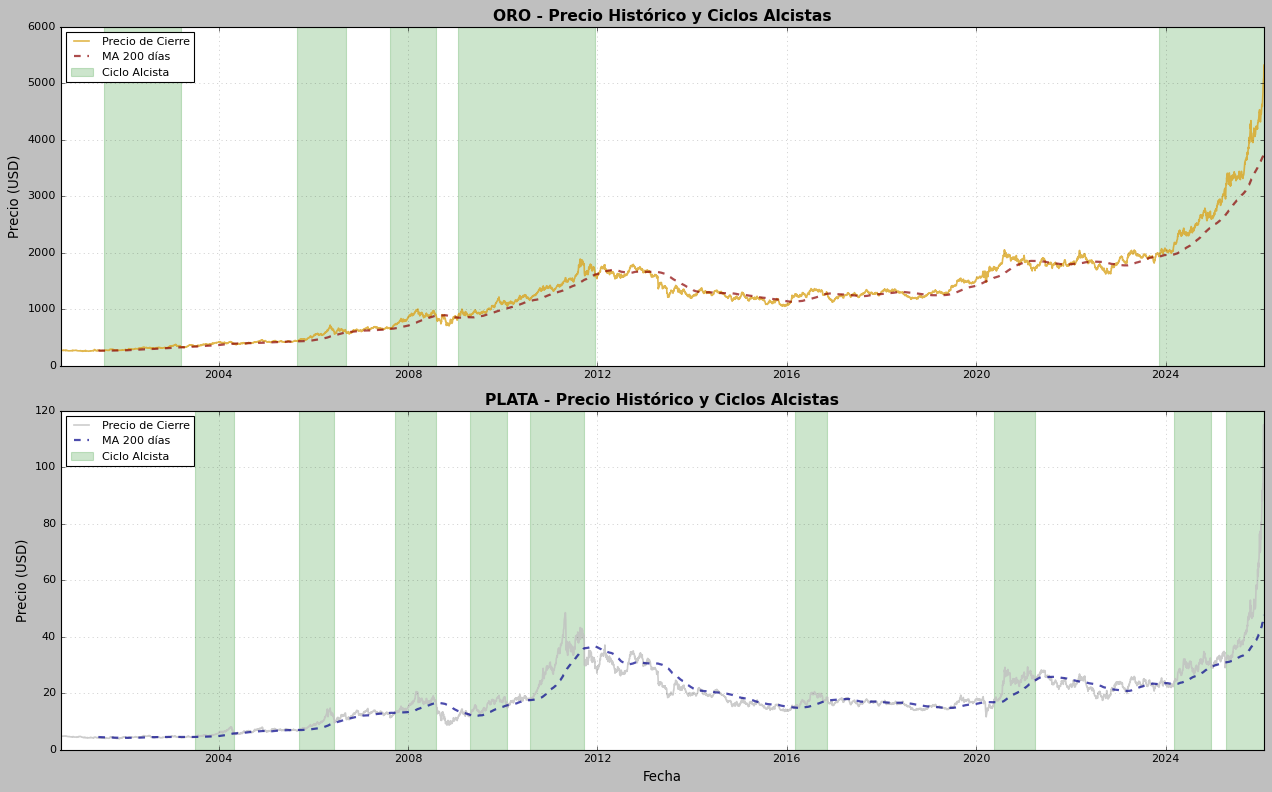

✓ Gráfico guardado: ciclos_alcistas_temporal.png


In [8]:
# ============================================================================
# CELDA 8: Gráfico 1 - Serie temporal con ciclos marcados
# ============================================================================
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# ORO
ax1 = axes[0]
ax1.plot(df_oro_ma.index, df_oro_ma['precio_cierre'], label='Precio de Cierre', 
         color='goldenrod', linewidth=1.5, alpha=0.8)
ax1.plot(df_oro_ma.index, df_oro_ma['ma_200'], label='MA 200 días', 
         color='darkred', linewidth=2, linestyle='--', alpha=0.7)

# Marcar ciclos alcistas
for idx, ciclo in ciclos_oro.iterrows():
    ax1.axvspan(ciclo['inicio'], ciclo['fin'], alpha=0.2, color='green', 
                label='Ciclo Alcista' if idx == 0 else '')

ax1.set_title('ORO - Precio Histórico y Ciclos Alcistas', fontsize=14, fontweight='bold')
ax1.set_ylabel('Precio (USD)', fontsize=12)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# PLATA
ax2 = axes[1]
ax2.plot(df_plata_ma.index, df_plata_ma['precio_cierre'], label='Precio de Cierre', 
         color='silver', linewidth=1.5, alpha=0.8)
ax2.plot(df_plata_ma.index, df_plata_ma['ma_200'], label='MA 200 días', 
         color='darkblue', linewidth=2, linestyle='--', alpha=0.7)

# Marcar ciclos alcistas
for idx, ciclo in ciclos_plata.iterrows():
    ax2.axvspan(ciclo['inicio'], ciclo['fin'], alpha=0.2, color='green', 
                label='Ciclo Alcista' if idx == 0 else '')

ax2.set_title('PLATA - Precio Histórico y Ciclos Alcistas', fontsize=14, fontweight='bold')
ax2.set_xlabel('Fecha', fontsize=12)
ax2.set_ylabel('Precio (USD)', fontsize=12)
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ciclos_alcistas_temporal.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: ciclos_alcistas_temporal.png")

### Gráfico 2: ¿Qué metal me hubiera dado más guita?

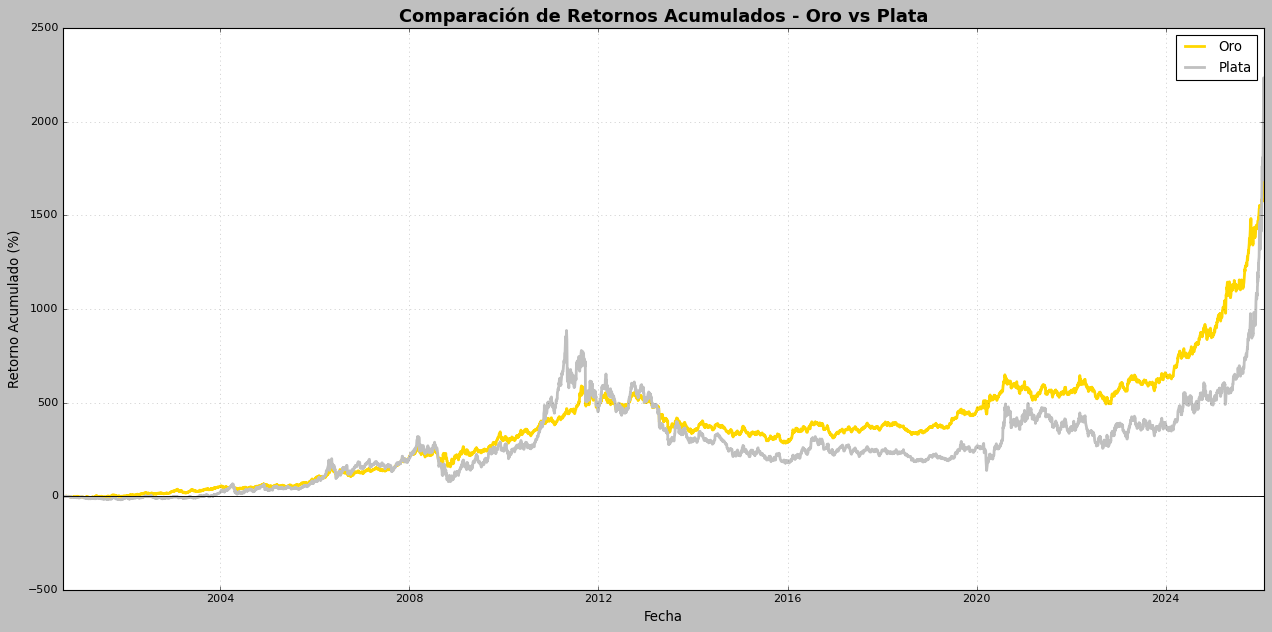

✓ Gráfico guardado: retornos_acumulados_comparacion.png


In [9]:
# ============================================================================
# CELDA 9: Gráfico 2 - Comparación de retornos acumulados
# ============================================================================
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(df_oro.index, df_oro['retorno_acumulado'] * 100, 
        label='Oro', color='gold', linewidth=2.5)
ax.plot(df_plata.index, df_plata['retorno_acumulado'] * 100, 
        label='Plata', color='silver', linewidth=2.5)

ax.set_title('Comparación de Retornos Acumulados - Oro vs Plata', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Retorno Acumulado (%)', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

plt.tight_layout()
plt.savefig('retornos_acumulados_comparacion.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: retornos_acumulados_comparacion.png")

### Gráfico 3: ¿Cuándo fue más peligroso estar adentro?

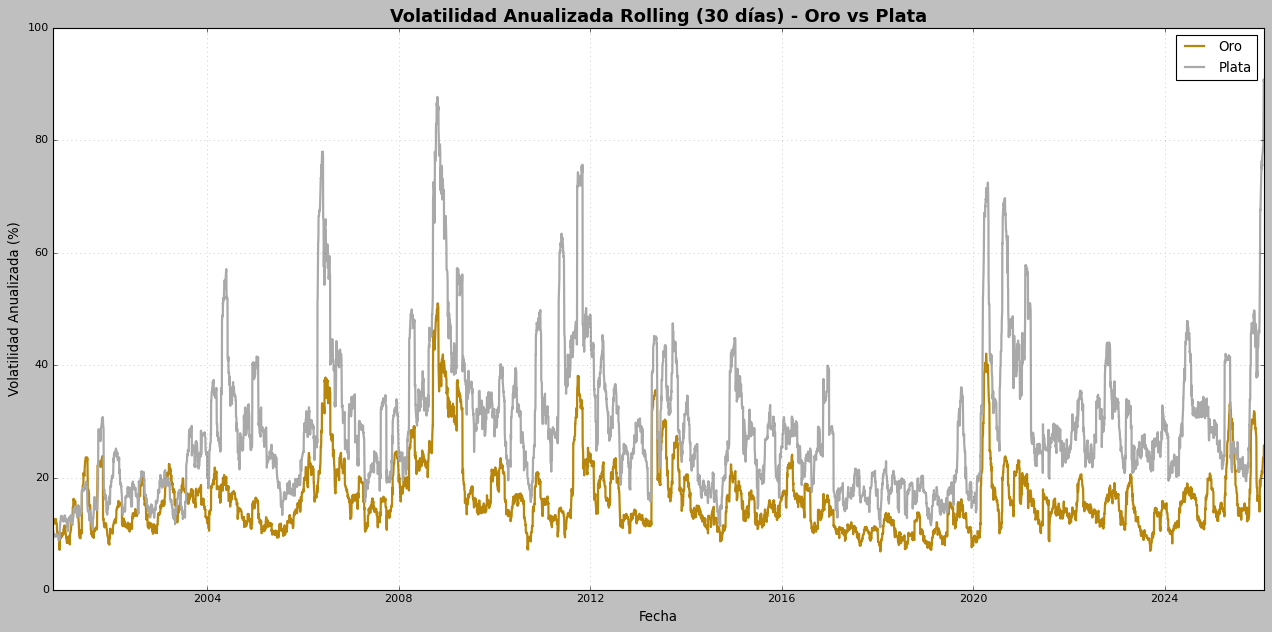

✓ Gráfico guardado: volatilidad_rolling.png


In [10]:
# ============================================================================
# CELDA 10: Gráfico 3 - Análisis de volatilidad rolling
# ============================================================================
# Calcular volatilidad rolling (30 días)
df_oro['vol_rolling_30'] = df_oro['retorno_diario'].rolling(window=30).std() * np.sqrt(252) * 100
df_plata['vol_rolling_30'] = df_plata['retorno_diario'].rolling(window=30).std() * np.sqrt(252) * 100

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(df_oro.index, df_oro['vol_rolling_30'], 
        label='Oro', color='darkgoldenrod', linewidth=2)
ax.plot(df_plata.index, df_plata['vol_rolling_30'], 
        label='Plata', color='darkgray', linewidth=2)

ax.set_title('Volatilidad Anualizada Rolling (30 días) - Oro vs Plata', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Volatilidad Anualizada (%)', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('volatilidad_rolling.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: volatilidad_rolling.png")

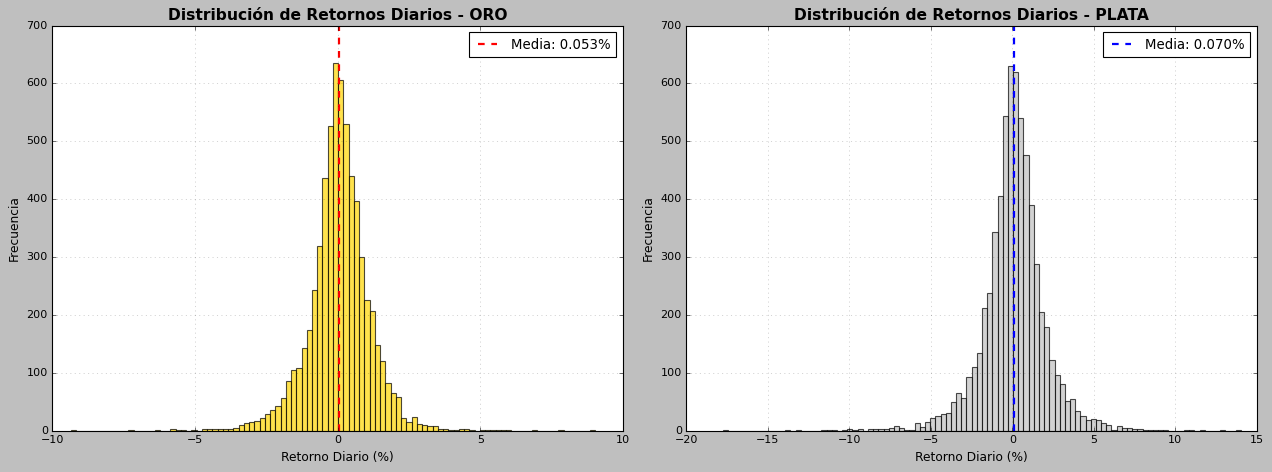

✓ Gráfico guardado: distribucion_retornos.png


In [11]:
# ============================================================================
# CELDA 11: Gráfico 4 - Distribución de retornos diarios
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histograma ORO
axes[0].hist(df_oro['retorno_diario'].dropna() * 100, bins=100, 
             color='gold', alpha=0.7, edgecolor='black')
axes[0].axvline(df_oro['retorno_diario'].mean() * 100, color='red', 
                linestyle='--', linewidth=2, label=f'Media: {df_oro["retorno_diario"].mean()*100:.3f}%')
axes[0].set_title('Distribución de Retornos Diarios - ORO', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Retorno Diario (%)', fontsize=11)
axes[0].set_ylabel('Frecuencia', fontsize=11)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Histograma PLATA
axes[1].hist(df_plata['retorno_diario'].dropna() * 100, bins=100, 
             color='silver', alpha=0.7, edgecolor='black')
axes[1].axvline(df_plata['retorno_diario'].mean() * 100, color='blue', 
                linestyle='--', linewidth=2, label=f'Media: {df_plata["retorno_diario"].mean()*100:.3f}%')
axes[1].set_title('Distribución de Retornos Diarios - PLATA', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Retorno Diario (%)', fontsize=11)
axes[1].set_ylabel('Frecuencia', fontsize=11)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('distribucion_retornos.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: distribucion_retornos.png")

### Gráfico 5: ¿Qué tan correlacionados están realmente?

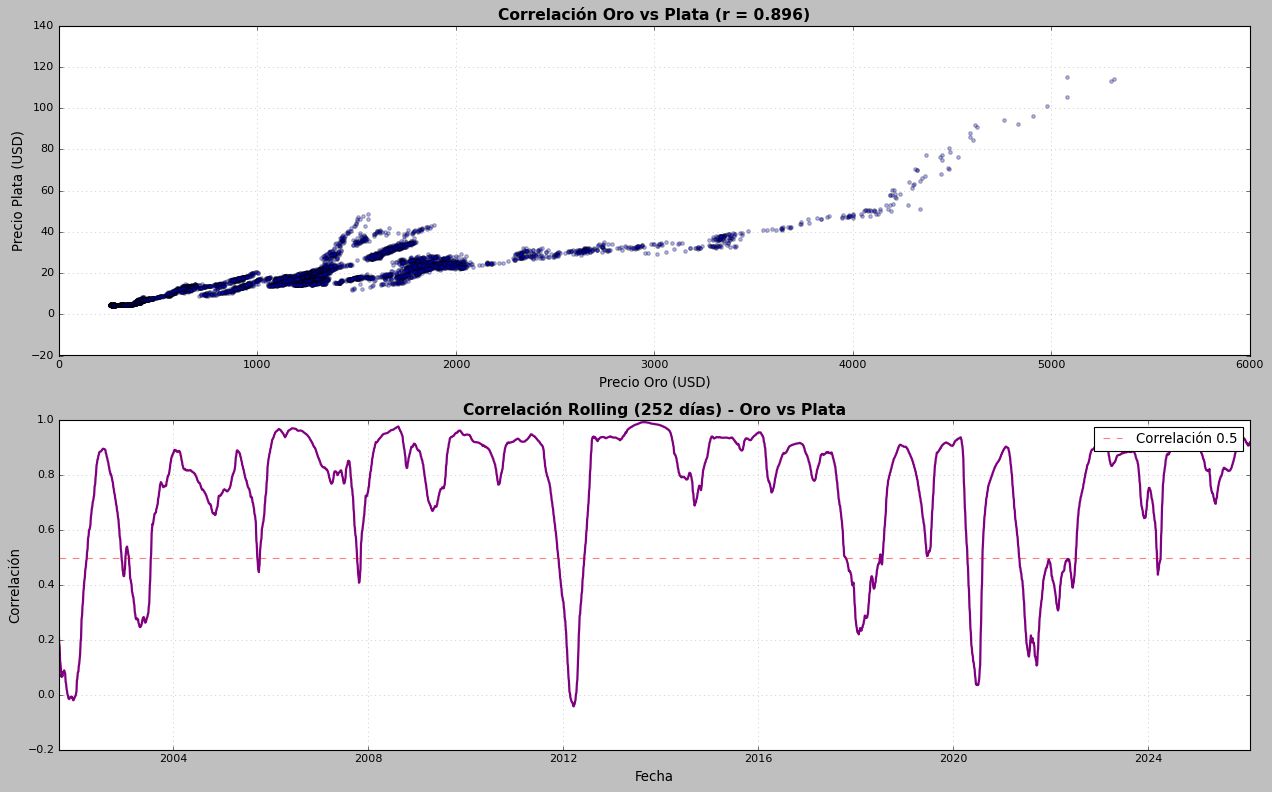

✓ Gráfico guardado: correlacion_oro_plata.png


In [12]:
# ============================================================================
# CELDA 12: Gráfico 5 - Correlación entre Oro y Plata
# ============================================================================
# Preparar datos para correlación
df_combined = pd.DataFrame({
    'Oro': df_oro['precio_cierre'],
    'Plata': df_plata['precio_cierre']
}).dropna()

# Calcular correlación rolling
correlacion_rolling = df_combined['Oro'].rolling(window=252).corr(df_combined['Plata'])

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Scatter plot
axes[0].scatter(df_combined['Oro'], df_combined['Plata'], alpha=0.3, s=10)
axes[0].set_title(f'Correlación Oro vs Plata (r = {df_combined.corr().iloc[0,1]:.3f})', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Precio Oro (USD)', fontsize=12)
axes[0].set_ylabel('Precio Plata (USD)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Correlación rolling
axes[1].plot(correlacion_rolling.index, correlacion_rolling, 
             color='purple', linewidth=2)
axes[1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Correlación 0.5')
axes[1].set_title('Correlación Rolling (252 días) - Oro vs Plata', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fecha', fontsize=12)
axes[1].set_ylabel('Correlación', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('correlacion_oro_plata.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: correlacion_oro_plata.png")

### Gráfico 6: ¿Cuánto duraron los ciclos?

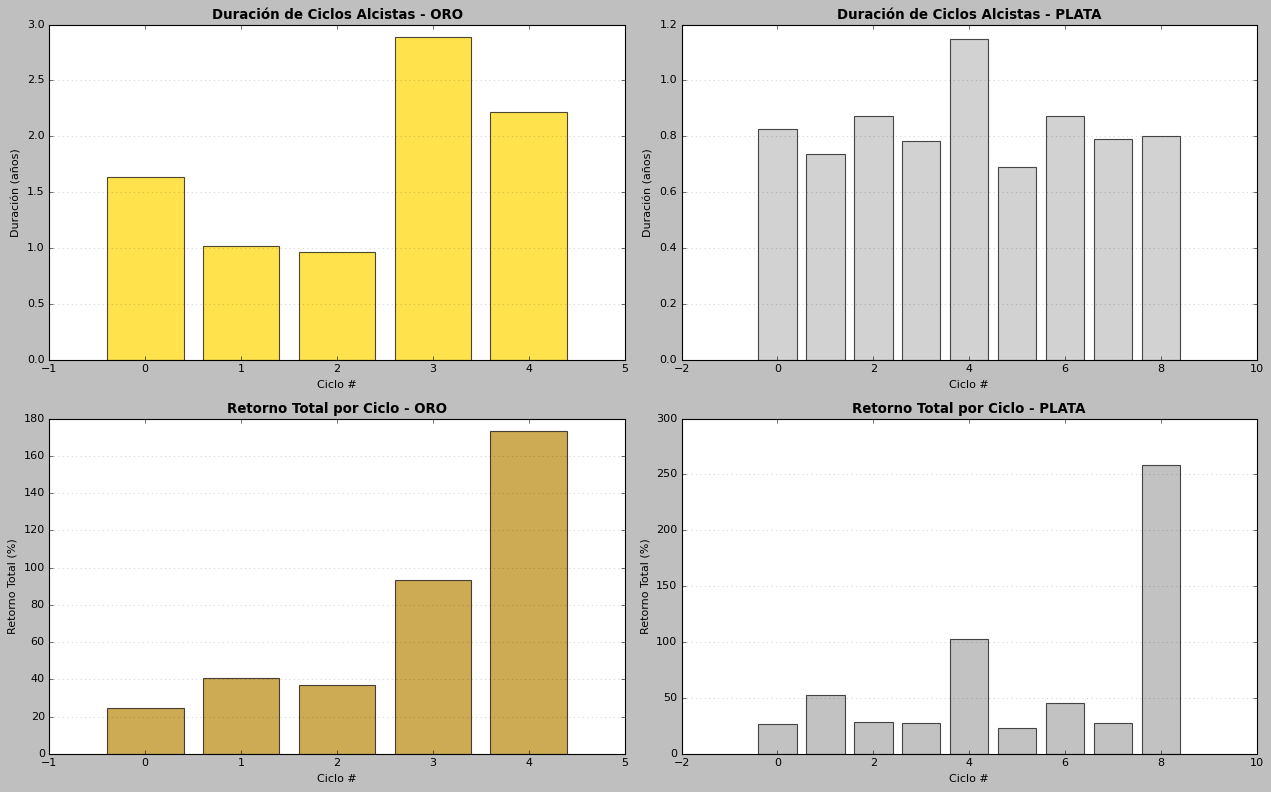

✓ Gráfico guardado: analisis_ciclos_barras.png


In [13]:
# ============================================================================
# CELDA 13: Gráfico 6 - Análisis de ciclos (duración y retornos)
# ============================================================================
if len(ciclos_oro) > 0 or len(ciclos_plata) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Duración de ciclos
    if len(ciclos_oro) > 0:
        axes[0, 0].bar(range(len(ciclos_oro)), ciclos_oro['duracion_dias'] / 365, 
                       color='gold', alpha=0.7, edgecolor='black')
        axes[0, 0].set_title('Duración de Ciclos Alcistas - ORO', fontsize=12, fontweight='bold')
        axes[0, 0].set_xlabel('Ciclo #', fontsize=10)
        axes[0, 0].set_ylabel('Duración (años)', fontsize=10)
        axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    if len(ciclos_plata) > 0:
        axes[0, 1].bar(range(len(ciclos_plata)), ciclos_plata['duracion_dias'] / 365, 
                       color='silver', alpha=0.7, edgecolor='black')
        axes[0, 1].set_title('Duración de Ciclos Alcistas - PLATA', fontsize=12, fontweight='bold')
        axes[0, 1].set_xlabel('Ciclo #', fontsize=10)
        axes[0, 1].set_ylabel('Duración (años)', fontsize=10)
        axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Retornos de ciclos
    if len(ciclos_oro) > 0:
        axes[1, 0].bar(range(len(ciclos_oro)), ciclos_oro['retorno_total'], 
                       color='darkgoldenrod', alpha=0.7, edgecolor='black')
        axes[1, 0].set_title('Retorno Total por Ciclo - ORO', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Ciclo #', fontsize=10)
        axes[1, 0].set_ylabel('Retorno Total (%)', fontsize=10)
        axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    if len(ciclos_plata) > 0:
        axes[1, 1].bar(range(len(ciclos_plata)), ciclos_plata['retorno_total'], 
                       color='darkgray', alpha=0.7, edgecolor='black')
        axes[1, 1].set_title('Retorno Total por Ciclo - PLATA', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Ciclo #', fontsize=10)
        axes[1, 1].set_ylabel('Retorno Total (%)', fontsize=10)
        axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('analisis_ciclos_barras.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Gráfico guardado: analisis_ciclos_barras.png")

In [14]:
# ============================================================================
# CELDA 14: Ratio Oro/Plata
# ============================================================================


# Calcular ratio oro/plata
df_ratio = pd.DataFrame({
    'oro': df_oro['precio_cierre'],
    'plata': df_plata['precio_cierre']
}).dropna()

df_ratio['ratio'] = df_ratio['oro'] / df_ratio['plata']

print(f"\nRATIO ORO/PLATA:")
print(f"  Actual: {df_ratio['ratio'].iloc[-1]:.1f}:1")
print(f"  Promedio histórico: {df_ratio['ratio'].mean():.1f}:1")
print(f"  Mínimo histórico: {df_ratio['ratio'].min():.1f}:1")
print(f"  Máximo histórico: {df_ratio['ratio'].max():.1f}:1")


RATIO ORO/PLATA:
  Actual: 46.6:1
  Promedio histórico: 69.2:1
  Mínimo histórico: 32.0:1
  Máximo histórico: 125.9:1


### Ratio: ¿Cuál está barato/caro relativamente?

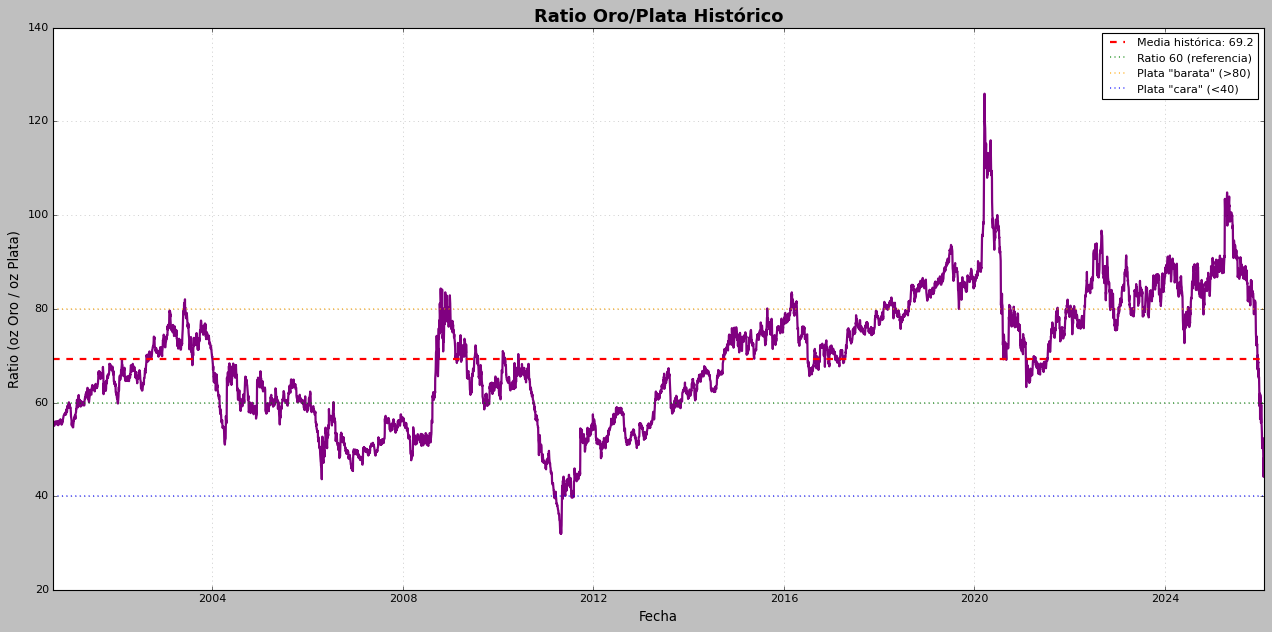

✓ Gráfico guardado: ratio_oro_plata.png


In [15]:
# ============================================================================
# CELDA 15: Gráfico del ratio Oro/Plata
# ============================================================================
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(df_ratio.index, df_ratio['ratio'], color='purple', linewidth=2)
ax.axhline(y=df_ratio['ratio'].mean(), color='red', linestyle='--', 
           linewidth=2, label=f'Media histórica: {df_ratio["ratio"].mean():.1f}')
ax.axhline(y=60, color='green', linestyle=':', linewidth=1.5, 
           label='Ratio 60 (referencia)', alpha=0.7)
ax.axhline(y=80, color='orange', linestyle=':', linewidth=1.5, 
           label='Plata "barata" (>80)', alpha=0.7)
ax.axhline(y=40, color='blue', linestyle=':', linewidth=1.5, 
           label='Plata "cara" (<40)', alpha=0.7)

ax.set_title('Ratio Oro/Plata Histórico', fontsize=16, fontweight='bold')
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Ratio (oz Oro / oz Plata)', fontsize=12)
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ratio_oro_plata.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: ratio_oro_plata.png")

In [18]:
# ============================================================================
# CELDA 16: Resumen ejecutivo y recomendaciones
# ============================================================================
print("\n" + "="*80)
print("RESUMEN EJECUTIVO Y CONCLUSIONES")
print("="*80)

# Calcular métricas finales
retorno_oro_total = ((df_oro['precio_cierre'].iloc[-1] / df_oro['precio_cierre'].iloc[0]) - 1) * 100
retorno_plata_total = ((df_plata['precio_cierre'].iloc[-1] / df_plata['precio_cierre'].iloc[0]) - 1) * 100

años_datos = (df_oro.index[-1] - df_oro.index[0]).days / 365

print(f"\n📊 PERFORMANCE GENERAL:")
print(f"  Período analizado: {años_datos:.1f} años")
print(f"  Retorno total ORO: {retorno_oro_total:.1f}%")
print(f"  Retorno total PLATA: {retorno_plata_total:.1f}%")
print(f"  CAGR ORO: {((1 + retorno_oro_total/100) ** (1/años_datos) - 1) * 100:.2f}%")
print(f"  CAGR PLATA: {((1 + retorno_plata_total/100) ** (1/años_datos) - 1) * 100:.2f}%")

print(f"\n🔄 CICLOS ALCISTAS:")
print(f"  ORO: {len(ciclos_oro)} ciclos identificados")
if len(ciclos_oro) > 0:
    print(f"    - Duración promedio: {ciclos_oro['duracion_dias'].mean()/365:.1f} años")
    print(f"    - Retorno promedio: {ciclos_oro['retorno_total'].mean():.1f}%")
    print(f"    - Mejor ciclo: {ciclos_oro['retorno_total'].max():.1f}%")

print(f"\n  PLATA: {len(ciclos_plata)} ciclos identificados")
if len(ciclos_plata) > 0:
    print(f"    - Duración promedio: {ciclos_plata['duracion_dias'].mean()/365:.1f} años")
    print(f"    - Retorno promedio: {ciclos_plata['retorno_total'].mean():.1f}%")
    print(f"    - Mejor ciclo: {ciclos_plata['retorno_total'].max():.1f}%")

print(f"\n💡 INSIGHTS CLAVE:")
print(f"""
1. La PLATA muestra mayor volatilidad y potencial de retornos extremos
2. El ORO ofrece protección más estable y consistente
3. Los ciclos alcistas suelen durar varios años (tendencias seculares)
4. La correlación entre ambos metales es alta pero variable
5. El ratio oro/plata puede usarse para timing táctico entre ambos

📈 ESTRATEGIAS SUGERIDAS:
- Core holding: 60-70% Oro, 30-40% Plata (portfolio defensivo)
- Momentum: Sobreponderación en metal con MA alcista más fuerte
- Mean reversion: Comprar plata cuando ratio >80, oro cuando ratio <45
- DCA: Dollar cost averaging en ambos metales para suavizar volatilidad

⚠️  RIESGOS A CONSIDERAR:
- Fortaleza del USD impacta negativamente
- Subida de tasas reales puede presionar precios
- Sustitución tecnológica (especialmente plata industrial)
- Regulación y fiscalidad de metales físicos
- Contango en futuros (costo de carry)
""")



RESUMEN EJECUTIVO Y CONCLUSIONES

📊 PERFORMANCE GENERAL:
  Período analizado: 25.4 años
  Retorno total ORO: 1841.7%
  Retorno total PLATA: 2213.1%
  CAGR ORO: 12.37%
  CAGR PLATA: 13.15%

🔄 CICLOS ALCISTAS:
  ORO: 5 ciclos identificados
    - Duración promedio: 1.7 años
    - Retorno promedio: 73.8%
    - Mejor ciclo: 173.4%

  PLATA: 9 ciclos identificados
    - Duración promedio: 0.8 años
    - Retorno promedio: 66.0%
    - Mejor ciclo: 258.3%

💡 INSIGHTS CLAVE:

1. La PLATA muestra mayor volatilidad y potencial de retornos extremos
2. El ORO ofrece protección más estable y consistente
3. Los ciclos alcistas suelen durar varios años (tendencias seculares)
4. La correlación entre ambos metales es alta pero variable
5. El ratio oro/plata puede usarse para timing táctico entre ambos

📈 ESTRATEGIAS SUGERIDAS:
- Core holding: 60-70% Oro, 30-40% Plata (portfolio defensivo)
- Momentum: Sobreponderación en metal con MA alcista más fuerte
- Mean reversion: Comprar plata cuando ratio >80, or

In [17]:
# ============================================================================
# CELDA 17: Cerrar conexión a base de datos
# ============================================================================
conn.close()
print("\n✓ Conexión a base de datos cerrada")
print("\nPara reconectar en futuras sesiones, ejecuta:")
print("conn = sqlite3.connect('metales_preciosos.db')")


✓ Conexión a base de datos cerrada

Para reconectar en futuras sesiones, ejecuta:
conn = sqlite3.connect('metales_preciosos.db')
